# Dynamic ecoregions

## Define inputs

In [1]:
# Inputs

input_file = "data/data-continental-united-states.csv"
# input_file = "data/data-nh-vt.csv"
geocode_precision = 4
# geocode_precision = 5
log_file = "run.log"
num_clusters = 60
taxon_filter = "Insecta"

## Set up logging

In [2]:
import logging

logging.basicConfig(filename=log_file, encoding="utf-8", level=logging.INFO)

## Data flow

/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


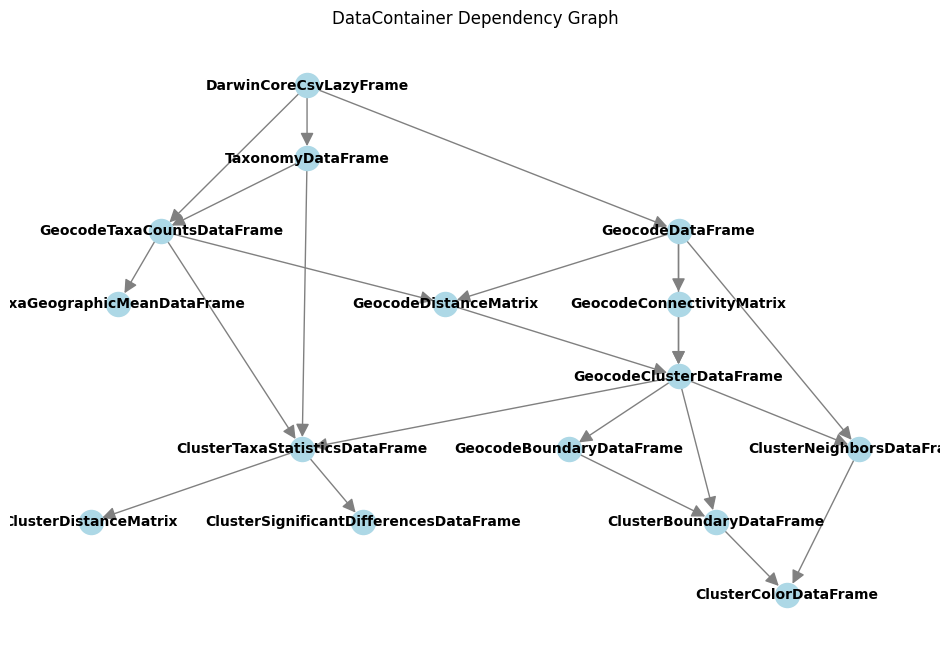

In [3]:
from src.dependency_graph import plot_dependency_graph

plot_dependency_graph()

## `DarwinCoreCsvLazyFrame`

### Build

In [4]:
from src.lazyframes.darwin_core_csv import DarwinCoreCsvLazyFrame

darwin_core_csv_lazy_frame = DarwinCoreCsvLazyFrame.build(input_file, taxon_filter=taxon_filter)

### Preview

In [5]:
darwin_core_csv_lazy_frame.lf.limit(3).collect()

gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,infraspecificEpithet,taxonRank,scientificName,verbatimScientificName,verbatimScientificNameAuthorship,countryCode,locality,stateProvince,occurrenceStatus,individualCount,publishingOrgKey,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,coordinatePrecision,elevation,elevationAccuracy,depth,depthAccuracy,eventDate,day,month,year,taxonKey,speciesKey,basisOfRecord,institutionCode,collectionCode,catalogNumber,recordNumber,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
str,str,str,enum,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,str,str,str,str,str,str,u64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""4424226317""","""50c9509d-22c7-4a22-a47d-8c4842…","""https://www.inaturalist.org/ob…","""Animalia""","""Arthropoda""","""Insecta""","""Odonata""","""Libellulidae""","""Sympetrum""",null,null,"""GENUS""","""Sympetrum Newman, 1833""","""Sympetrum""",null,"""US""",null,"""New York""","""PRESENT""",null,"""28eb1a3f-1c15-4a95-931a-4af90e…",42.96266,-76.740947,"""2191.0""",null,null,null,null,null,"""2019-09-06T10:30""","""6""","""9""","""2019""",1428195,null,"""HUMAN_OBSERVATION""","""iNaturalist""","""Observations""","""32505913""",null,"""Amy Guala""","""2019-09-11T01:33:07""","""CC_BY_NC_4_0""","""Amy Guala""","""Amy Guala""",null,null,"""2024-12-03T00:52:33.467Z""","""StillImage""","""COORDINATE_ROUNDED;CONTINENT_D…"
"""2423028148""","""50c9509d-22c7-4a22-a47d-8c4842…","""https://www.inaturalist.org/ob…","""Animalia""","""Arthropoda""","""Insecta""","""Lepidoptera""","""Geometridae""","""Nematocampa""","""Nematocampa resistaria""",null,"""SPECIES""","""Nematocampa resistaria (Herric…","""Nematocampa resistaria""",null,"""US""",null,"""Vermont""","""PRESENT""",null,"""28eb1a3f-1c15-4a95-931a-4af90e…",43.822608,-72.641412,"""5.0""",null,null,null,null,null,"""2019-09-11T22:08:52""","""11""","""9""","""2019""",1991012,"""1991012""","""HUMAN_OBSERVATION""","""iNaturalist""","""Observations""","""32566956""",null,"""bugguytad""","""2019-09-12T02:25:38""","""CC_BY_NC_4_0""","""bugguytad""","""bugguytad""",null,null,"""2024-12-03T01:38:46.617Z""","""StillImage;StillImage;StillIma…","""COORDINATE_ROUNDED;CONTINENT_D…"
"""2423041120""","""50c9509d-22c7-4a22-a47d-8c4842…","""https://www.inaturalist.org/ob…","""Animalia""","""Arthropoda""","""Insecta""","""Odonata""","""Coenagrionidae""","""Argia""","""Argia moesta""",null,"""SPECIES""","""Argia moesta (Hagen, 1861)""","""Argia moesta""",null,"""US""",null,"""Texas""","""PRESENT""",null,"""28eb1a3f-1c15-4a95-931a-4af90e…",30.99463,-103.662658,null,null,null,null,null,null,"""2019-09-08T09:01""","""8""","""9""","""2019""",5051399,"""5051399""","""HUMAN_OBSERVATION""","""iNaturalist""","""Observations""","""32612673""",null,"""Todd Fitzgerald""","""2019-09-12T22:11:30""","""CC_BY_NC_4_0""","""Todd Fitzgerald""","""Todd Fitzgerald""",null,null,"""2024-12-03T01:38:10.816Z""","""StillImage""","""COORDINATE_ROUNDED;CONTINENT_D…"


## `GeohashDataFrame`

### Build

In [6]:
from src.dataframes.geocode import GeocodeDataFrame

geocode_dataframe = GeocodeDataFrame.build(
    darwin_core_csv_lazy_frame,
    geocode_precision,
)

### Preview

In [7]:
geocode_dataframe.df

geocode,center,direct_neighbors,direct_and_indirect_neighbors
str,struct[2],list[str],list[str]
"""840e491ffffffff""","{49.369298,-67.913007}","[""840e497ffffffff"", ""840e493ffffffff"", ""840e49bffffffff""]","[""840e497ffffffff"", ""840e493ffffffff"", ""840e49bffffffff""]"
"""840e493ffffffff""","{48.946311,-67.83016}","[""840e49bffffffff"", ""840e491ffffffff"", … ""842b14dffffffff""]","[""840e49bffffffff"", ""840e491ffffffff"", … ""842b14dffffffff""]"
"""840e497ffffffff""","{49.104076,-68.442117}","[""840e491ffffffff"", ""840e4bbffffffff"", … ""840e493ffffffff""]","[""840e491ffffffff"", ""840e4bbffffffff"", … ""840e493ffffffff""]"
"""840e49bffffffff""","{49.208357,-67.299825}","[""840e491ffffffff"", ""840e493ffffffff"", … ""842b327ffffffff""]","[""840e491ffffffff"", ""840e493ffffffff"", … ""842b327ffffffff""]"
"""840e4b1ffffffff""","{49.410776,-69.681628}","[""840e4b7ffffffff"", ""840e4b3ffffffff"", ""840e4bbffffffff""]","[""840e4b7ffffffff"", ""840e4b3ffffffff"", ""840e4bbffffffff""]"
…,…,…,…
"""844da39ffffffff""","{29.518714,-68.472339}",[],"[""844db1bffffffff""]"
"""844db1bffffffff""","{29.95183,-70.105581}",[],"[""844d86dffffffff"", ""842a5b3ffffffff"", ""844da39ffffffff""]"
"""844db61ffffffff""","{31.586253,-71.677466}",[],"[""842acc9ffffffff"", ""844d86dffffffff""]"


## `TaxonomyDataFrame`

### Build

In [8]:
from src.dataframes.taxonomy import TaxonomyDataFrame

taxonomy_dataframe = TaxonomyDataFrame.build(darwin_core_csv_lazy_frame)

### Preview

In [9]:
taxonomy_dataframe.df

taxonId,kingdom,phylum,class,order,family,genus,species,taxonRank,scientificName
u32,enum,str,str,str,str,str,str,str,str
0,"""Animalia""","""Arthropoda""","""Insecta""","""Hemiptera""","""Aphididae""","""Neophyllaphis""","""Neophyllaphis varicolor""","""SPECIES""","""Neophyllaphis varicolor Miller…"
1,"""Animalia""","""Arthropoda""","""Insecta""","""Lepidoptera""","""Sesiidae""","""Osminia""","""Osminia ruficornis""","""SPECIES""","""Osminia ruficornis (Edwards, 1…"
2,"""Animalia""","""Arthropoda""","""Insecta""","""Hemiptera""","""Membracidae""","""Palonica""","""Palonica pyramidata""","""SPECIES""","""Palonica pyramidata"""
3,"""Animalia""","""Arthropoda""","""Insecta""","""Hemiptera""","""Pseudococcidae""","""Spilococcus""","""Spilococcus larreae""","""SPECIES""","""Spilococcus larreae Ferris, 19…"
4,"""Animalia""","""Arthropoda""","""Insecta""","""Lepidoptera""","""Limacodidae""","""Euclea""","""Euclea incisa""","""SPECIES""","""Euclea incisa Harv., 1876"""
…,…,…,…,…,…,…,…,…,…
37926,"""Animalia""","""Arthropoda""","""Insecta""","""Coleoptera""","""Carabidae""","""Pasimachus""","""Pasimachus subsulcatus""","""SPECIES""","""Pasimachus subsulcatus Say, 18…"
37927,"""Animalia""","""Arthropoda""","""Insecta""","""Orthoptera""","""Acrididae""","""Orphulella""","""Orphulella speciosa""","""SPECIES""","""Orphulella speciosa (Scudder, …"
37928,"""Animalia""","""Arthropoda""","""Insecta""","""Coleoptera""","""Tenebrionidae""","""Eleodes""","""Eleodes littoralis""","""SPECIES""","""Eleodes littoralis (Eschscholt…"


## `GeohashSpeciesCountsDataFrame`

### Build

In [10]:
from src.dataframes.geocode_taxa_counts import GeocodeTaxaCountsDataFrame

geocode_taxa_counts_dataframe = GeocodeTaxaCountsDataFrame.build(
    darwin_core_csv_lazy_frame,
    geocode_precision,
    taxonomy_dataframe,
)

### Preview

In [11]:
geocode_taxa_counts_dataframe.df

geocode,taxonId,count
str,u32,u32
"""840e491ffffffff""",19045,1
"""840e491ffffffff""",4270,1
"""840e491ffffffff""",11446,1
"""840e491ffffffff""",18904,2
"""840e491ffffffff""",24039,1
…,…,…
"""844da39ffffffff""",13138,1
"""844db1bffffffff""",21590,1
"""844db61ffffffff""",26093,1


## `GeocodeConnectivityMatrix`

### Build

In [12]:
from src.matrices.geocode_connectivity import GeocodeConnectivityMatrix

geocode_connectivity_matrix = GeocodeConnectivityMatrix.build(geocode_dataframe)

### Shape

In [13]:
geocode_connectivity_matrix._connectivity_matrix.shape

(6061, 6061)

### Preview

In [14]:
geocode_connectivity_matrix._connectivity_matrix

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

## `GeocodeDistanceMatrix`

In [15]:
from src.matrices.geocode_distance import GeocodeDistanceMatrix

print(GeocodeDistanceMatrix.__doc__)


    A distance matrix where each column and row is a geocode, and the cell at the intersection of a
    column and row is the similarity (or distance) between the two geocodes. Internally it is stored
    as a condensed distance matrix, which is a one-dimensional array containing the upper triangular
    part of the distance matrix.
    


### Build

In [16]:
geocode_distance_matrix = GeocodeDistanceMatrix.build(
    geocode_taxa_counts_dataframe,
    geocode_dataframe,
)

/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Shape

In [17]:
geocode_distance_matrix.squareform().shape

(6061, 6061)

### Preview

In [18]:
geocode_distance_matrix.squareform()

array([[0.        , 0.00098627, 0.00072143, ..., 0.00140247, 0.00142978,
        0.00161891],
       [0.00098627, 0.        , 0.00168513, ..., 0.00059725, 0.00056945,
        0.00067951],
       [0.00072143, 0.00168513, 0.        , ..., 0.00209943, 0.00212322,
        0.00230154],
       ...,
       [0.00140247, 0.00059725, 0.00209943, ..., 0.        , 0.0003365 ,
        0.00059712],
       [0.00142978, 0.00056945, 0.00212322, ..., 0.0003365 , 0.        ,
        0.00040253],
       [0.00161891, 0.00067951, 0.00230154, ..., 0.00059712, 0.00040253,
        0.        ]])

## `GeohashClusterDataFrame`

### Build

In [19]:
from src.dataframes.geocode_cluster import GeocodeClusterDataFrame

geocode_cluster_dataframe = GeocodeClusterDataFrame.build(
    geocode_dataframe,
    geocode_distance_matrix,
    geocode_connectivity_matrix,
    num_clusters,
)

### Preview

In [20]:
geocode_cluster_dataframe.df.limit(3)

geocode,cluster
str,u32
"""840e491ffffffff""",5
"""840e493ffffffff""",5
"""840e497ffffffff""",5


In [21]:
# # TMP

# from src.dataframes.geocode_cluster import GeocodeClusterDataFrame
# from sklearn.metrics import silhouette_score

# results = []

# for i in range(2, 200):
#     geocode_cluster_dataframe = GeocodeClusterDataFrame.build(
#         geocode_dataframe,
#         distance_matrix,
#         connectivity_matrix,
#         num_clusters=i,
#     )
#     score = silhouette_score(
#         X=distance_matrix.squareform(),
#         labels=geocode_cluster_dataframe.df["cluster"],
#         metric="precomputed",
#     )
#     print(f"{i}: {score}")
#     results.append((i, score))

# results

## `ClusterNeighborsDataframe`

### Build

In [22]:
from src.dataframes.cluster_neighbors import ClusterNeighborsDataFrame

cluster_neighbors_dataframe = ClusterNeighborsDataFrame.build(
    geocode_dataframe,
    geocode_cluster_dataframe,
)

### Preview

In [23]:
cluster_neighbors_dataframe.df

cluster,direct_neighbors,direct_and_indirect_neighbors
u32,list[u32],list[u32]
0,[],[52]
1,"[37, 9, … 28]","[37, 9, … 28]"
2,[6],[6]
3,"[32, 36, … 29]","[32, 36, … 29]"
4,[6],[6]
…,…,…
55,"[5, 7]","[5, 7]"
56,[15],[15]
57,[7],[7]


## `ClusterTaxaStatisticsDataFrame`

### Build

In [24]:
from src.dataframes.cluster_taxa_statistics import ClusterTaxaStatisticsDataFrame

cluster_taxa_statistics_dataframe = ClusterTaxaStatisticsDataFrame.build(
    geocode_taxa_counts_dataframe,
    geocode_cluster_dataframe,
    taxonomy_dataframe,
)

### Preview

In [25]:
cluster_taxa_statistics_dataframe.df

cluster,taxonId,count,average
u32,u32,u32,f64
null,8402,129,0.00001
null,26885,4,3.2092e-7
null,34489,1,8.0231e-8
null,6556,67,0.000005
null,1200,1,8.0231e-8
…,…,…,…
21,16353,3,0.000023
4,36036,8,0.004447
32,15054,4,0.000054


## `ClusterSignificantDifferencesDataFrame`

### Build

In [26]:
from src.dataframes.cluster_significant_differences import (
    ClusterSignificantDifferencesDataFrame,
)

cluster_significant_differences_dataframe = (
    ClusterSignificantDifferencesDataFrame.build(
        cluster_taxa_statistics_dataframe,
    )
)

### Preview

In [27]:
cluster_significant_differences_dataframe.df.limit(3)

cluster,taxonId,percentage_difference
u32,u32,f64
0,25018,111946.521036
0,28407,4871.225331
0,22041,1377.098789


## `GeocodeBoundaryDataFrame`

### Build

In [28]:
from src.dataframes.geocode_boundary import GeocodeBoundaryDataFrame

geocode_boundary_dataframe = GeocodeBoundaryDataFrame.build(
    geocode_cluster_dataframe,
)

### Preview

In [29]:
geocode_boundary_dataframe.df

geocode,boundary
str,binary
"""840e491ffffffff""","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x116L$\xd0\xf0P\xc0E(\xdb\x0f\x9f\xccH@\xcbY\xae\xf4m\x09Q\xc0\x7f\xb1\x1db$\xc8H@\xac\x17\xa5\xb4\xe9\x12Q\xc0\xbe\\xddY\xb9\xaaH""…"
"""840e493ffffffff""","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x0a\xcc\xdc\x8b\x94\xebP\xc0\xf1\xb7\xad\xfea\x96H@g\x13M)\xf3\x03Q\xc0\xa1\xec\xeb\xef\xee\x91H@Z\xd7t\xe1]\x0dQ\xc0Ymw\xd5\x9ctH""…"
"""840e497ffffffff""","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\xac\x17\xa5\xb4\xe9\x12Q\xc0\xbe\\xddY\xb9\xaaH@H\xab\xf9*^+Q\xc0\x12\xa9\xf8\xbb\x03\xa6H@\xc6\xe6\x87q\x9d4Q\xc0\xe7\x80zj\x8c\x88H""…"
"""840e49bffffffff""","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\xd3y|Og\xc9P\xc0r[\xca\xdf\xde\xb7H@s\x85\xe4\xb9\xed\xe1P\xc0\x86\xfcJ\x04\xa7\xb3H@\x0a\xcc\xdc\x8b\x94\xebP\xc0\xf1\xb7\xad\xfea\x96H""…"
"""840e4b1ffffffff""","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\xef\x12L\xbf\x97bQ\xc0\xdd\x11k\x94D\xd2H@\xc3c\xe6\xe23{Q\xc0\xc6\xf8a$\x07\xcdH@\x9a^\xf5&\x18\x84Q\xc0\xbc\x8d)\x96G\xafH""…"
…,…
"""844da39ffffffff""","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x17u\x9f]\x15\x18Q\xc0ws|5?\xb2=@\xa0/\x1e?\x1f(Q\xc0}\x829$\x9c\xa9=@\xc1\xb8.\xc15.Q\xc0\x11\x88\x1c\xcf\x1f|=""…"
"""844db1bffffffff""","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00O6\xe7\xc1\xea\x80Q\xc0\xbeJt\xd9\xe9!>@\x9b\xde\xdc\xf4\x15\x91Q\xc0Q2\xed\xfdi\x18>@\xd8\xcf\x06z\xdd\x96Q\xc0d\x05\xed\xa0%\xea=""…"
"""844db61ffffffff""","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\xb9E\xd1\xc2\xaf\xe5Q\xc0\xad\xb2^\xa2-\xc6?@\xc5\xf1\xafR_\xf6Q\xc0V0!\xe5\xa3\xbb?@l\xe5\xef5\xfa\xfbQ\xc0\x15\x0d\xe5:\x86\x8b?""…"


## `ClusterBoundaryDataFrame`

### Build

In [30]:
from src.dataframes.cluster_boundary import ClusterBoundaryDataFrame

cluster_boundary_dataframe = ClusterBoundaryDataFrame.build(
    geocode_cluster_dataframe,
    geocode_boundary_dataframe,
)

### Preview

In [31]:
cluster_boundary_dataframe.df

cluster,boundary
u32,binary
0,"b""\x01\x06\x00\x00\x00\x02\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\xd7wS\xd2+1`\xc08\x0cE\xe4{\xe5D@80\xcbV\xa7*`\xc0""\xf0*#T\xfcD@\x81\x05\x822`!""…"
1,"b""\x01\x06\x00\x00\x00\x05\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\xc9\xea#3\x07\xcd\\xc0\x148\xf1|z\xf39@R\xc9?\xfe7\xbf\\xc0\x8e\xde\x20\x1a&\x1e:@y$\x04\xfb\x1c\xae""…"
2,"b""\x01\x06\x00\x00\x00\x0c\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x0f\x00\x00\x00\xa0R\x07~\xeb\xc4T\xc0\xb1\x05~k8:5@\xda\x06\x00!u\xd1T\xc0A~e\x00\x9bY5@V[\x9e\x94\x94\xd0""…"
3,"b""\x01\x06\x00\x00\x00\x02\x00\x00\x00\x01\x03\x00\x00\x00\x0b\x00\x00\x00C\x02\x00\x00\xafH\xab\xa9!\xc3W\xc0\xa7T\xdcz\xc0}A@w\x08\x14\xa6\x07\xb3W\xc0\xfb\xd1\x94\xa3[\x8dA@\x17\x92\x9bx\xab\xb3""…"
4,"b""\x01\x06\x00\x00\x00\x0c\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x11\x00\x00\x00\xe4\xbd\xf7d\x89\xa4S\xc0;\x0dU\xcfk\x207@\x9c\xef\x9a>&\xb0S\xc0\x1f/\xd3\x10\xee@7@F\x89\xf1\x99\xbf\xae""…"
…,…
55,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x1b\x00\x00\x00\xa1j\xfd\xfa\xd4|T\xc0E\xa9\xa62\x7f\xd1E@n#I\x9fV\x91T\xc0O\x12\xdf-\xc1\xc7E@\x17}L\x8f\xf9\xa1T\xc0\x86\xe1\x88\xba\x8b\xdbE""…"
56,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\xbfb\xf33\xc7SY\xc0\x94-\xe4\x9f\xdf!8@\x1e\x82\x9c0\x14EY\xc09\x0e\x8798G8@\xf6\x06\xbfB\x84FY\xc0no\x1d\x00\x98\x888""…"
57,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00O\x00\x00\x00\xc0\xa5\xc3\x963\xfeR\xc04\xcf\x88<7\xf5D@\xe2A*\xf3t\xf8R\xc0\xdd{12\xd5\x11E@\xafM$\xa29\x07S\xc0\xb1\x06s7\x18'E""…"


## `ClusterDistanceMatrix`

### Build

In [32]:
from src.matrices.cluster_distance import ClusterDistanceMatrix

cluster_distance_matrix = ClusterDistanceMatrix.build(
    cluster_taxa_statistics_dataframe,
)

### Preview

In [33]:
cluster_distance_matrix.squareform()

array([[0.        , 0.57000106, 0.67098447, ..., 1.00001248, 1.00001248,
        1.00001248],
       [0.57000106, 0.        , 0.84476609, ..., 1.00000327, 1.00000327,
        1.00000327],
       [0.67098447, 0.84476609, 0.        , ..., 0.99999197, 0.99999197,
        0.99999197],
       ...,
       [1.00001248, 1.00000327, 0.99999197, ..., 0.        , 0.71603784,
        0.        ],
       [1.00001248, 1.00000327, 0.99999197, ..., 0.71603784, 0.        ,
        0.71603784],
       [1.00001248, 1.00000327, 0.99999197, ..., 0.        , 0.71603784,
        0.        ]])

## `ClusterColorDataFrame`

### Build

In [34]:
from src.dataframes.cluster_color import ClusterColorDataFrame

cluster_colors_dataframe = ClusterColorDataFrame.build(
    cluster_neighbors_dataframe,
    cluster_boundary_dataframe,
    cluster_taxa_statistics_dataframe,
    color_method="taxonomic",
    # color_method="geographic",
)

/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions/.venv/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Preview

In [35]:
cluster_colors_dataframe.df

cluster,color
u32,str
22,"""#e66806"""
12,"""#e77206"""
52,"""#e7640a"""
21,"""#e8810a"""
7,"""#f14812"""
…,…
58,"""#bb4b4f"""
35,"""#bb4955"""
49,"""#b94a59"""


## `GeocodeSilhouetteScoreDataFrame`

### Build

In [36]:
from src.dataframes.geocode_silhouette_score import GeocodeSilhouetteScoreDataFrame

geocode_silhouette_score_dataframe = GeocodeSilhouetteScoreDataFrame.build(
    cluster_neighbors_dataframe,
    geocode_distance_matrix,
    geocode_cluster_dataframe,
)

### Preview

In [37]:
geocode_silhouette_score_dataframe.df.sort(by="silhouette_score")

geocode,silhouette_score
str,f64
"""84442ddffffffff""",-0.983728
"""8445497ffffffff""",-0.980535
"""84458b3ffffffff""",-0.979969
"""8444b19ffffffff""",-0.976499
"""844588dffffffff""",-0.975795
…,…
"""84446dbffffffff""",0.545205
"""84489b3ffffffff""",0.545789
"""84489b5ffffffff""",0.54787


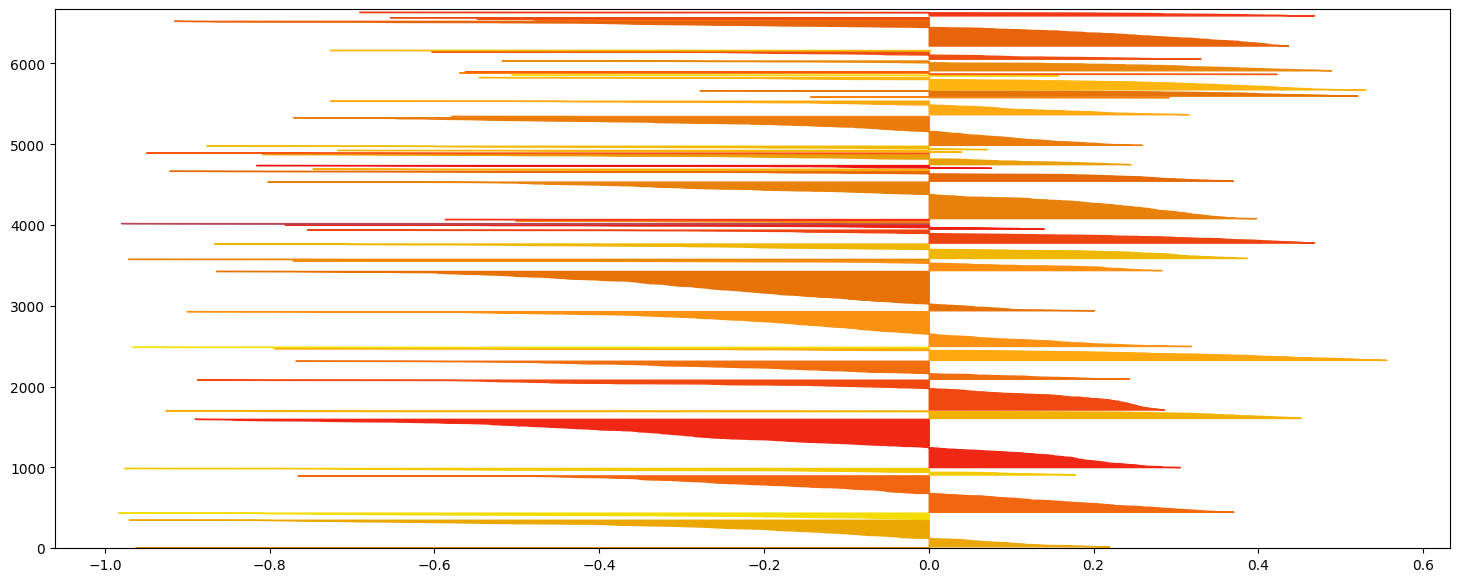

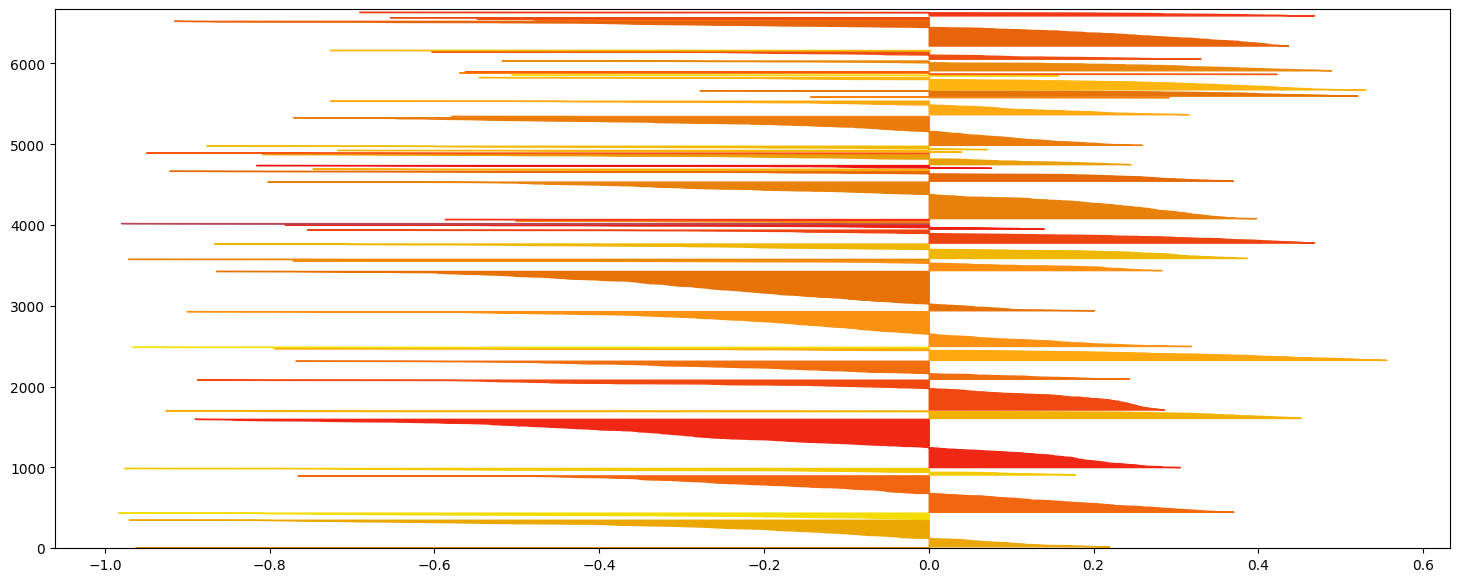

In [38]:
from src.plot.silhouette_score import plot_silhouette_scores

plot_silhouette_scores(
    geocode_cluster_dataframe,
    geocode_distance_matrix,
    geocode_silhouette_score_dataframe,
    cluster_colors_dataframe,
)

## Build and plot GeoJSON feature collection

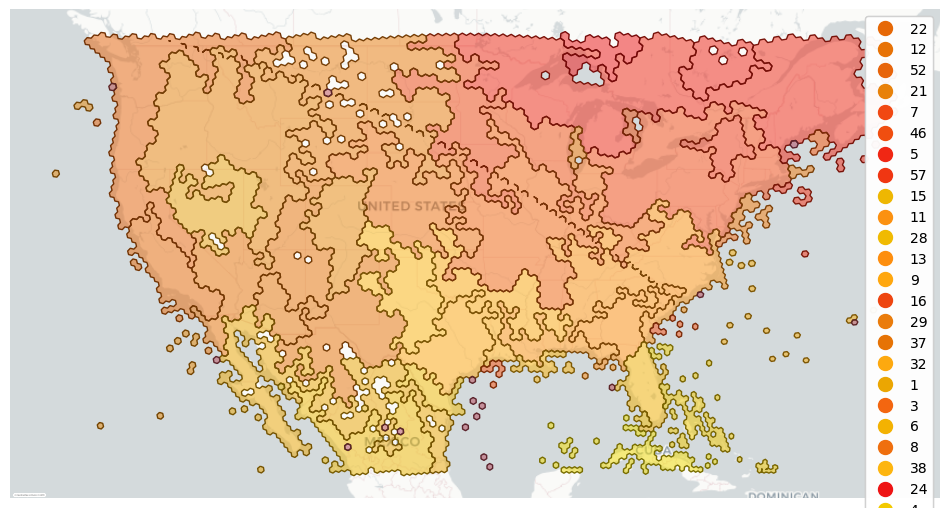

In [39]:
from src.geojson import build_geojson_feature_collection, write_geojson
from src.render import plot_clusters
from src import output
import matplotlib.pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = [12, 7]

feature_collection = build_geojson_feature_collection(
    cluster_boundary_dataframe,
    cluster_colors_dataframe,
)

write_geojson(feature_collection, output.get_geojson_path())
plot_clusters(feature_collection)

## Build and display HTML output

In [40]:
from src.html_output import prepare_full_report_data, render_html, write_html

report_data = prepare_full_report_data(
    cluster_colors_dataframe,
    cluster_significant_differences_dataframe,
    taxonomy_dataframe,
    feature_collection,
)
html_content = render_html("cluster_report.html", report_data)
html_output = output.get_html_path()
write_html(html_content, html_output)

## Dimensionality reduction plot

/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions/.venv/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Axes: >

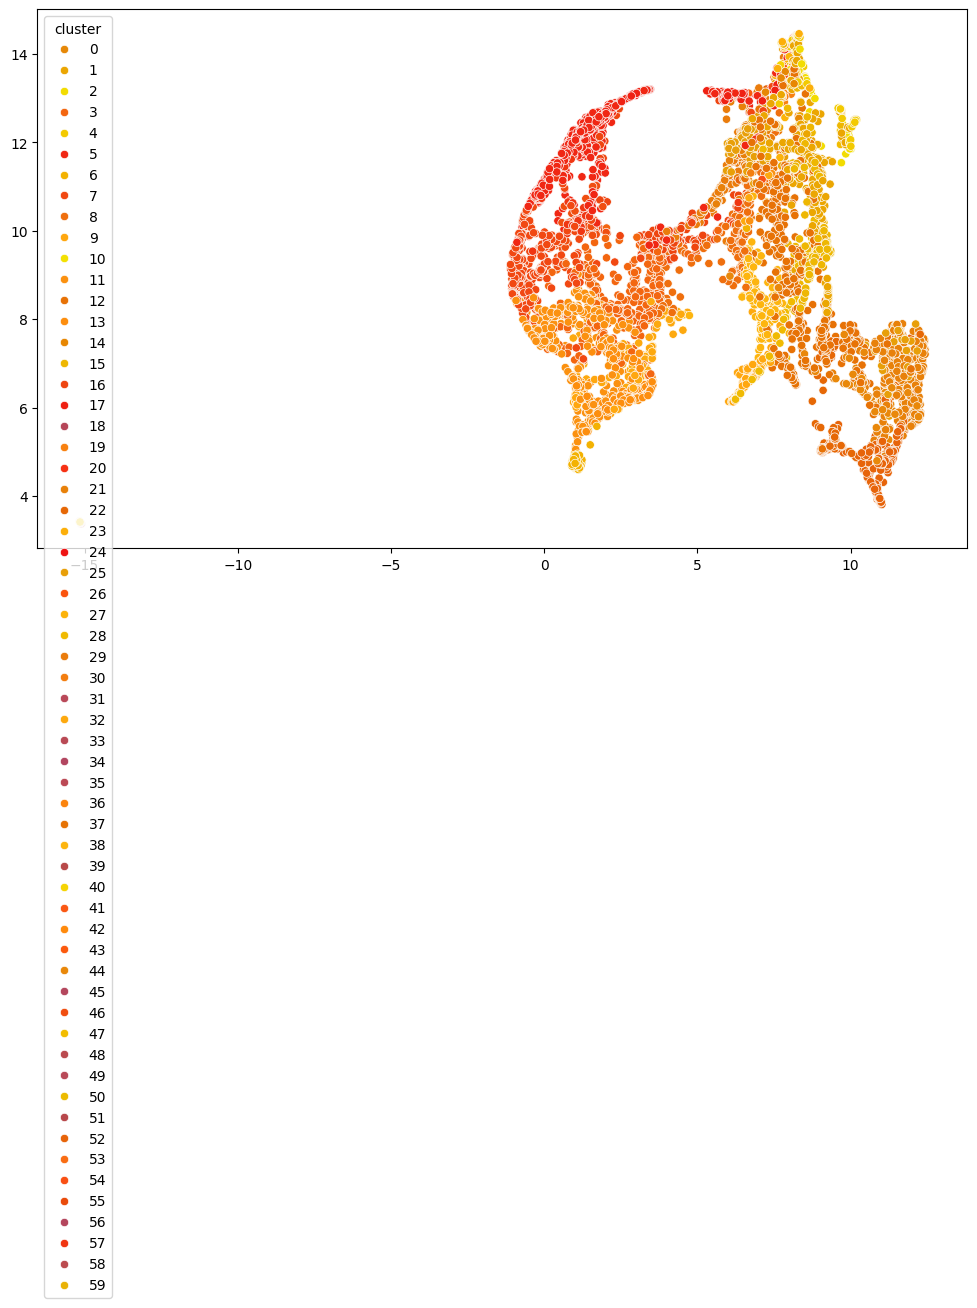

In [41]:
from src.plot.dimnesionality_reduction import create_dimensionality_reduction_plot

create_dimensionality_reduction_plot(
    geocode_distance_matrix,
    geocode_cluster_dataframe,
    cluster_colors_dataframe,
    method="umap",
)


## Clustermap visualization

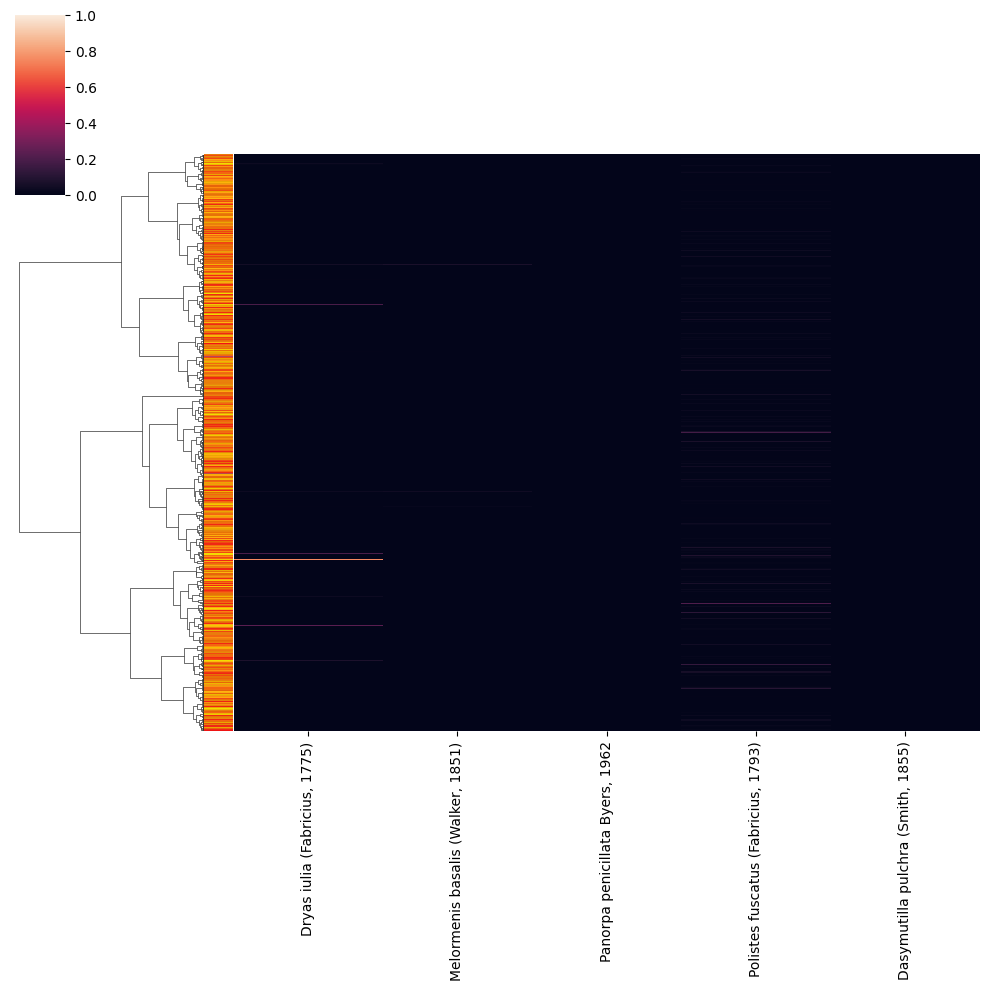

In [43]:
from src.plot.cluster_taxa import create_cluster_taxa_heatmap

create_cluster_taxa_heatmap(
    geocode_dataframe=geocode_dataframe,
    geocode_cluster_dataframe=geocode_cluster_dataframe,
    cluster_colors_dataframe=cluster_colors_dataframe,
    geocode_distance_matrix=geocode_distance_matrix,
    cluster_significant_differences_dataframe=cluster_significant_differences_dataframe,
    taxonomy_dataframe=taxonomy_dataframe,
    geocode_taxa_counts_dataframe=geocode_taxa_counts_dataframe,
    cluster_taxa_statistics_dataframe=cluster_taxa_statistics_dataframe,
    limit_species=5,
)